# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

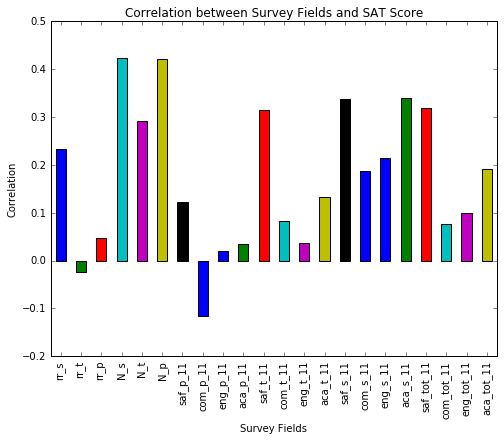

In [78]:
# There are several fields that originally came from a survey of parents, teachers, and students.
# Create a bar plot of the correlations between these fields and sat_score.

fig, ax = plt.subplots(figsize=(8,6))
combined.corr()["sat_score"][survey_fields].plot.bar()
plt.xlabel('Survey Fields')
plt.ylabel('Correlation')
plt.title('Correlation between Survey Fields and SAT Score')

### Observations
* Number of student responses (``N_s``), teacher responses (``N_p``), and parent responses (``N_p``) had a positive correlation with average SAT score. This makes sense since total enrollment was identified to have a positive correlation with average SAT score.
* Communication score based on parent's response (``com_p_11``) had a negative correlation with average SAT score. This is somewhat surprising as it would be expected to have a positive correlation.

# Investigate safety scores

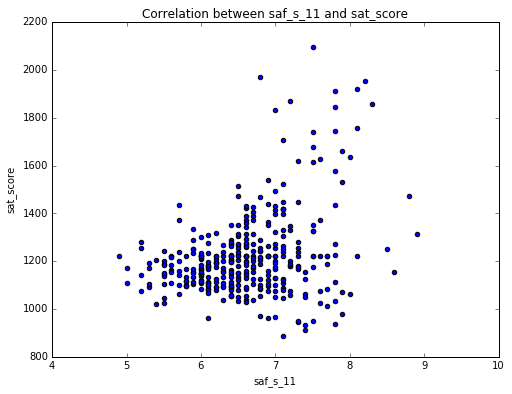

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.xlabel('saf_s_11')
plt.ylabel('sat_score')
plt.title('Correlation between saf_s_11 and sat_score')

### Observations
* Perceived safety at school by students ("saf_s_11") had a positive correlation with SAT score.

In [23]:
# Map out safety scores.
combined_groupby_dist = combined.groupby('school_dist')
combined_dist_mean = combined_groupby_dist[['lat', 'lon','saf_s_11']].mean()
combined_dist_mean = combined_dist_mean.reset_index()

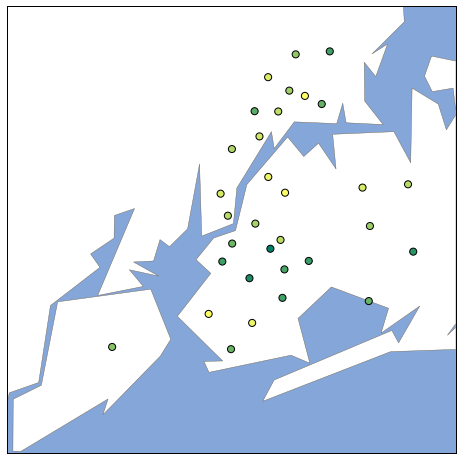

In [75]:
fig, ax = plt.subplots(figsize=(12,8))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = combined_dist_mean["lon"].tolist()
latitudes = combined_dist_mean["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=combined_dist_mean["saf_s_11"], cmap="summer")

### Observations
* The boroughs of Queens and Manhattan tend to have higher safety scores (shown in yellow), while Brooklyn tends to have lower safety scores (shown in green).

# Investigate racial differences in SAT scores.

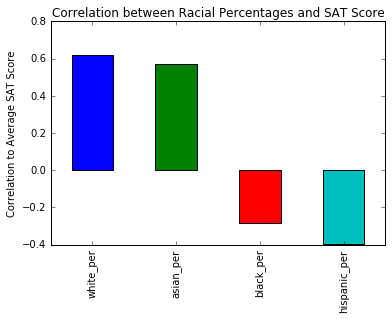

In [117]:
racial_pers = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()["sat_score"][racial_pers].plot.bar()
plt.ylabel('Correlation to Average SAT Score')
plt.title('Correlation between Racial Percentages and SAT Score')

### Observations
* The percentages of white students and percentage of asian students had  positive correlations with SAT score.
* The percentages of black students and percentage of hispanic students had  negative correlations with SAT score.

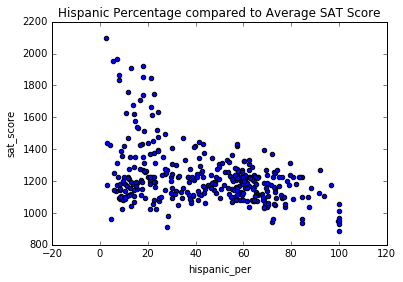

In [112]:
# Explore schools with low SAT scores and high values for hispanic_per.
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.title('Hispanic Percentage compared to Average SAT Score')

### Observations
* The percentage of hispanic students had a negative correlation with SAT score.

In [80]:
# Research schools with a hispanic_per greater than 95%.
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Observations
* There were 8 schools where more than 95% of the students were hispanic. These schools included dual-language schools and schools serving spanish-speaking students.

In [81]:
# Research schools with a hispanic_per less than 10% and an average SAT score greater than 1,800.
combined[(combined['hispanic_per'] < 95) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Observations
* There were 9 schools where less than 10% of the students were hispanic and average SAT scores were above 1,800. These included technical, magnet, and STEM-focused schools.

# Investigate gender differences in SAT scores.

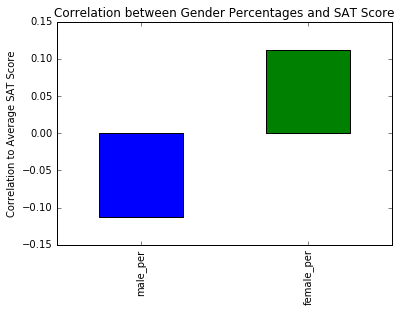

In [116]:
gender_pers = ['male_per', 'female_per']

combined.corr()["sat_score"][gender_pers].plot.bar()
plt.ylabel('Correlation to Average SAT Score')
plt.title('Correlation between Gender Percentages and SAT Score')

### Observations
* The percentage of male students had a weak negative correlation with average SAT scores.
* The percentage of female students had a weak positive correlation with average SAT scores.

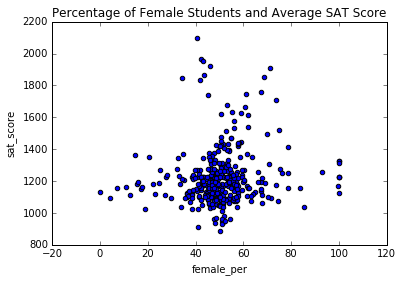

In [106]:
# Investigate schools with high SAT scores and a high female_per.
#fig, ax = plt.subplots(figsize=(8,6))
combined.plot.scatter(x='female_per', y='sat_score')
plt.title('Percentage of Female Students and Average SAT Score')

### Observations
* There is no clear correlation trend between percentage of female students and average SAT score.

In [87]:
# Research schools with a female_per greater than 60% and an average SAT score greater than 1,700.

combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Observations

* There were 5 schools where more than 60% of the students were female and average SAT scores were above 1,700. These included college-prepatory, magnet schools, and performing arts schools.

# Investigate the relationship between AP scores and SAT scores.

In [96]:
# Calculate the percentage of students in each school that took an AP exam.
combined.rename(columns={'AP Test Takers ': 'AP Test Takers'}, inplace=True)
combined['ap_per'] = combined['AP Test Takers'] / combined['total_enrollment']

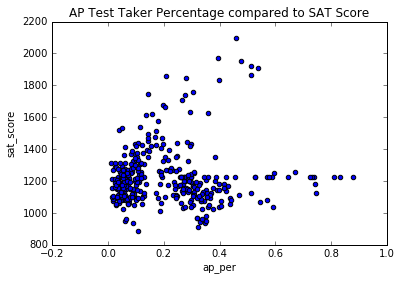

In [104]:
# Create a scatter plot of ap_per vs. sat_score.
combined.plot.scatter(x='ap_per', y='sat_score')
plt.title('AP Test Taker Percentage compared to SAT Score')

### Observations
* The Percentage of AP test takers is positively correlated with average SAT score.
* There are many schools that appear to have an average SAT score of approximately 1,200.

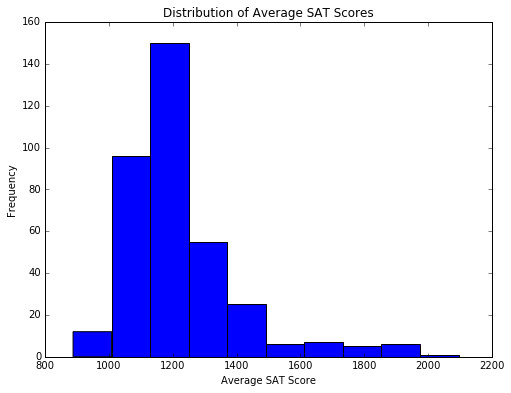

In [74]:
# Check distribution of SAT scores
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(combined['sat_score'])
plt.xlabel('Average SAT Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average SAT Scores')

### Analysis next steps
* Determe whether there's a correlation between class size and SAT scores
* Figure out which neighborhoods have the best schools
    * Combine this information with a dataset containing property values to find the least expensive neighborhoods that have good schools.
* Investigate the differences between parent, teacher, and student responses to surveys.
* Assign scores to schools based on ``sat_score`` and other attributes.